## COSC 425 Final Project: ML Analysis of Benign and Malignant Tumors - A. Walsh & C. Condon

### Import libraries

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from math import floor
from sklearn import tree
import seaborn as sns
import random
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr

### Read in data, isolate features and labels

In [54]:
data = pd.read_csv("data.csv")
data.drop(['Unnamed: 32'], axis=1, inplace=True)
y = data['diagnosis'].map({'M':1,'B':0})
X = data.drop(['id', 'diagnosis'], axis=1)
y = np.array(y)
feature_list = list(X.columns)
X = np.array(X)
avgModelPerformance = []

### Oversampling
- Run these cells to oversample the data and get 50/50 split
- Notebook ran with and without oversampling for visualizations in presentation

In [55]:
def oversample_data(X, y): 
    oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [56]:
X, y = oversample_data(X, y)
#copy of features to keep pre-scaling values, with oversampling
X_unscaled = X
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, train_size=0.875, random_state=42)

### Boxplot of data

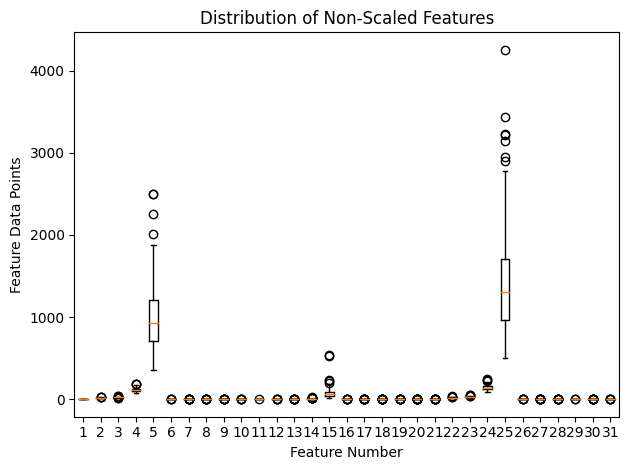

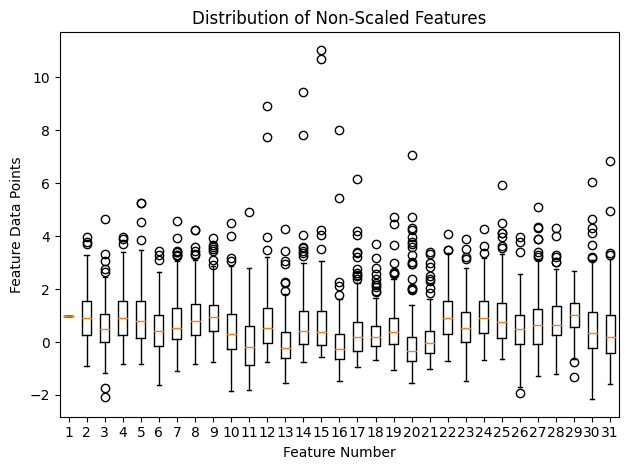

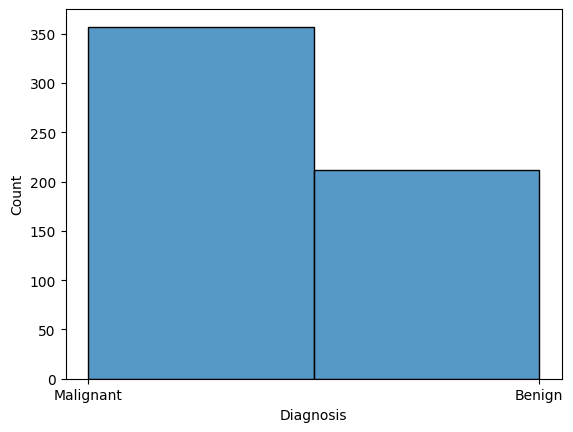

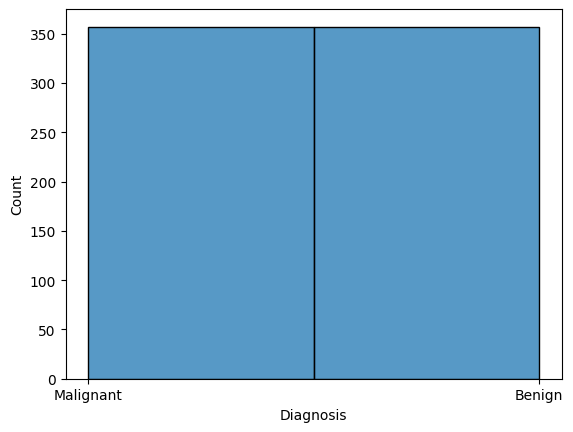

<AxesSubplot:>

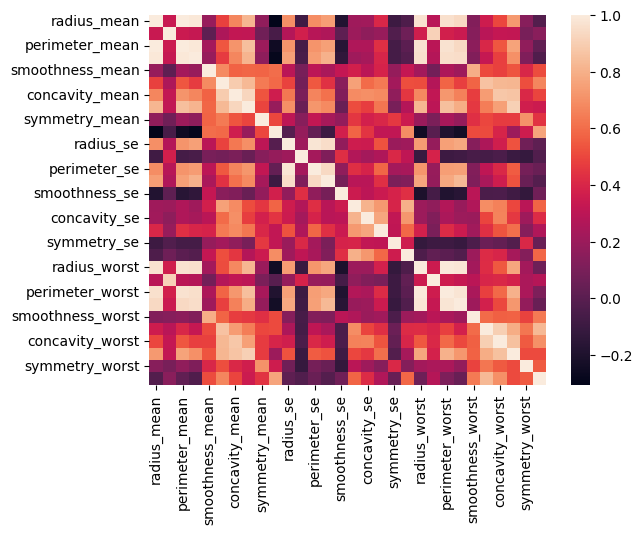

In [57]:
dataCopy = pd.read_csv("data.csv")
dataCopy.drop(["Unnamed: 32", "id"], axis=1, inplace=True)
dataCopy['diagnosis']=dataCopy['diagnosis'].map({'M':1,'B':0})
def genBoxPlot(data, scaled=False):
    if scaled:
        tempScaler = StandardScaler()
        cols = data.columns.tolist()
        cols.remove("diagnosis")
        data[cols] = tempScaler.fit_transform(data[cols])
    plt.boxplot(data[data["diagnosis"] == 1])
    plt.xlabel("Feature Number")
    plt.ylabel("Feature Data Points")
    plt.title("Distribution of Non-Scaled Features")
    plt.tight_layout()
    plt.show()

genBoxPlot(dataCopy, scaled=False)
genBoxPlot(dataCopy, scaled=True)

def genBarGraph(data, oversampled=False):
    dataY = np.array(data["diagnosis"])
    dataX = np.array(data.loc[:, data.columns != 'diagnosis'])
    if oversampled:
        oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
        dataX, dataY = oversample.fit_resample(dataX, dataY)
    dataY = np.array(dataY)
    sns.histplot(dataY, bins=2)
    plt.xlabel("Diagnosis")
    plt.xticks(range(2), ["Malignant", "Benign"])
    plt.show()

genBarGraph(dataCopy, oversampled=False)
genBarGraph(dataCopy, oversampled=True)
dataCopy = pd.DataFrame(columns=feature_list, data=X)
sns.heatmap(dataCopy.corr())

### Logistic regression for probabilistic interpretation of data

In [58]:
def evalModelPerf(model, params, X_train_sub, y_train_sub):
    #evaluate each combination of parameters and display performance, using validation set
    grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=10)
    grid_result = grid.fit(X_train_sub, y_train_sub)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return (grid_result.best_score_, means)

lgr = LogisticRegression(random_state=0)
lgr.fit(X_train, y_train)
lgrProbs = lgr.predict_proba(X_train)
avgModelPerformance.append(evalModelPerf(lgr, {"random_state": [0]}, X_train_sub, y_train_sub)[0])

Best: 0.925837 using {'random_state': 0}
0.925837 (0.033559) with: {'random_state': 0}


### Show averages of feature values at each percentile of confidence in logistic regression
- entries in X_train to their nearest probability (0-100%, multiples of 5)

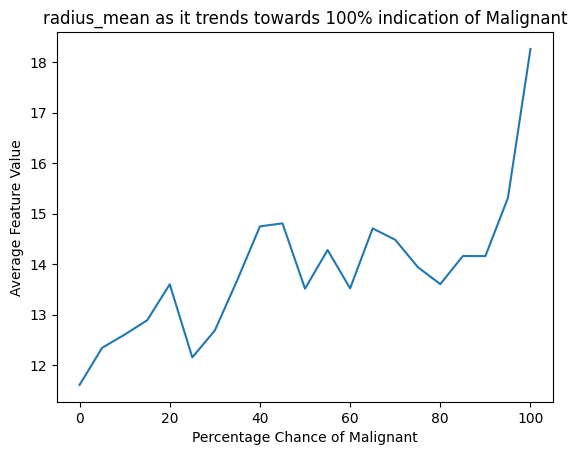

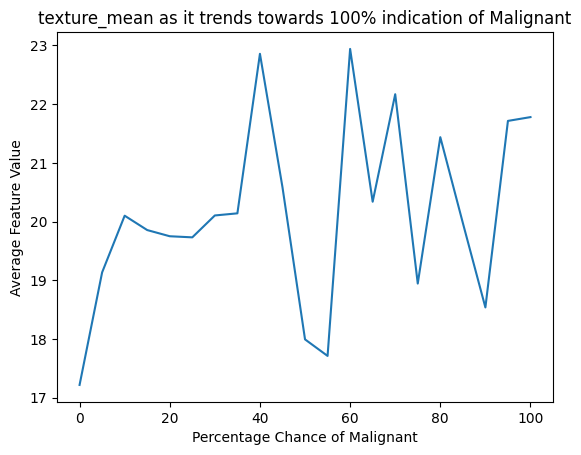

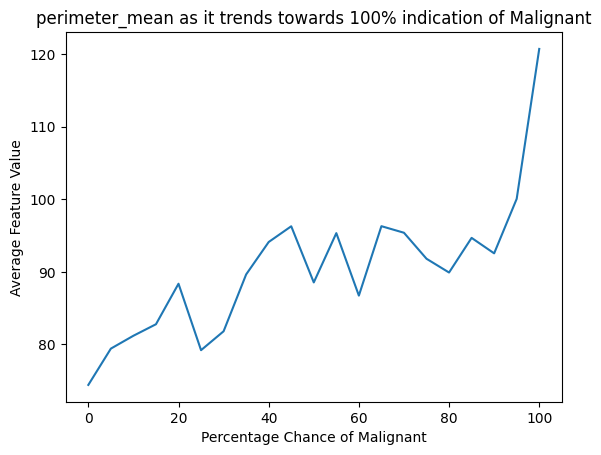

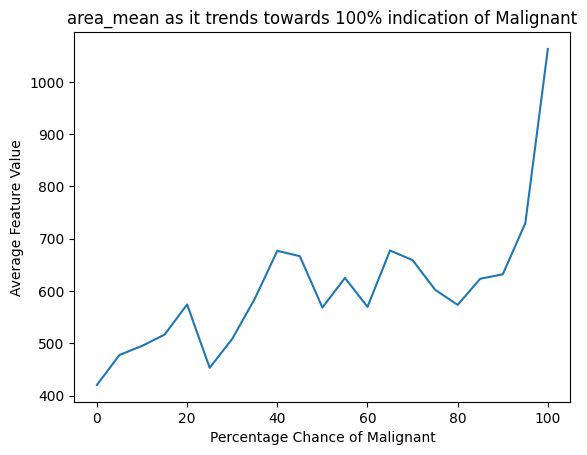

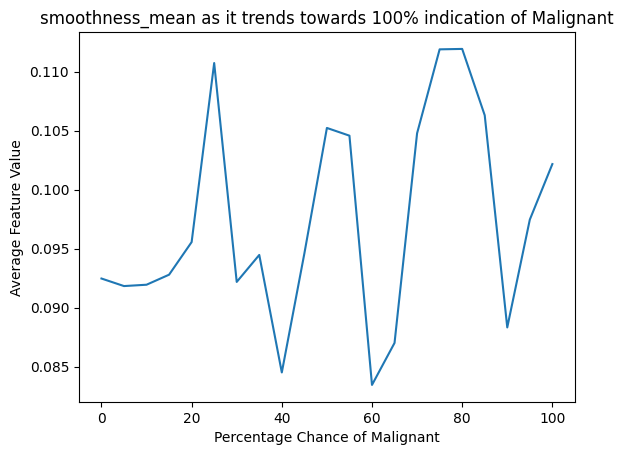

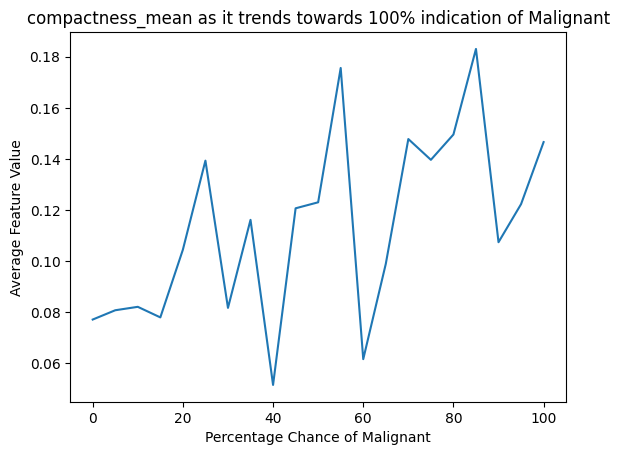

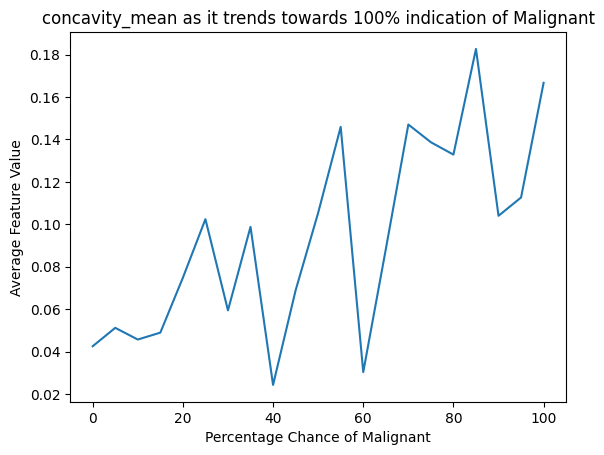

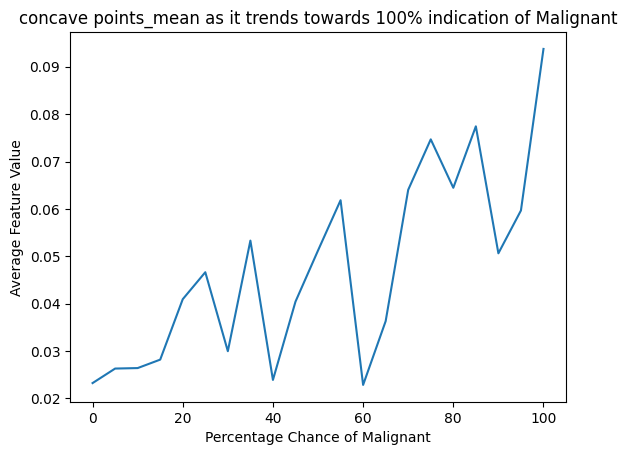

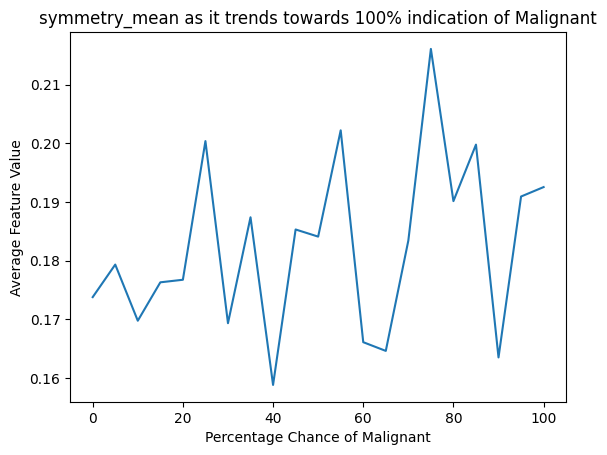

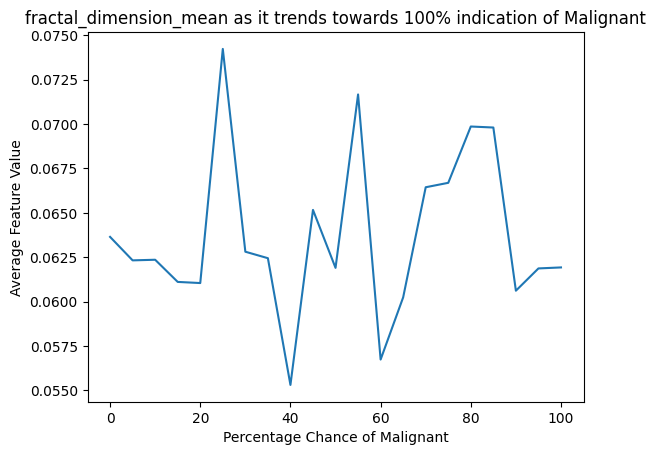

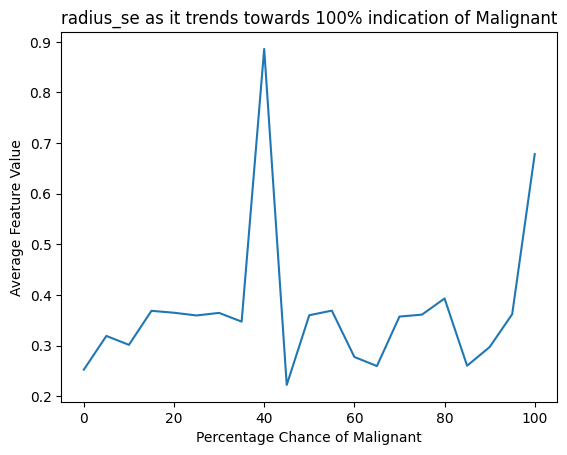

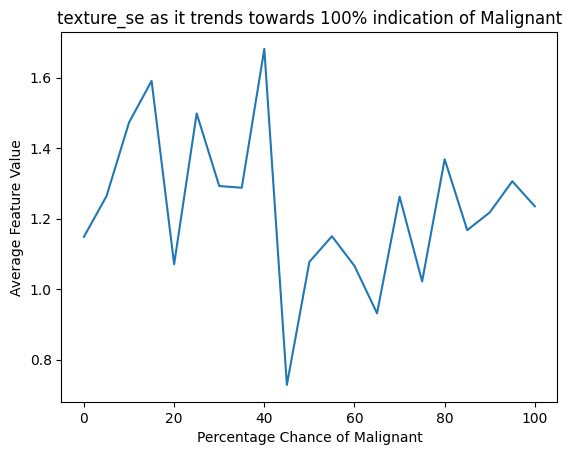

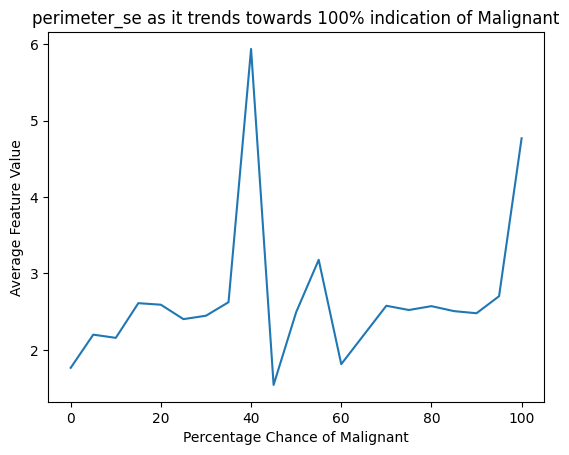

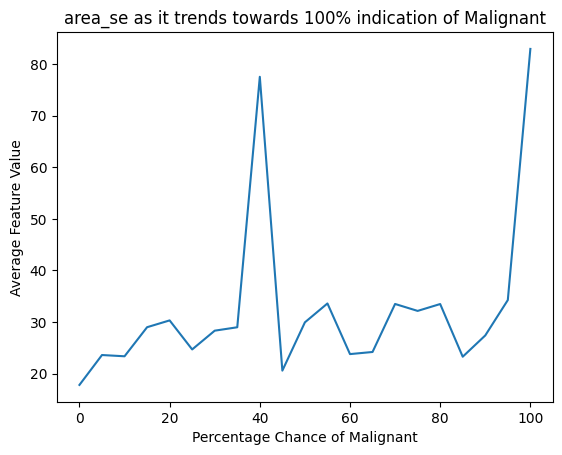

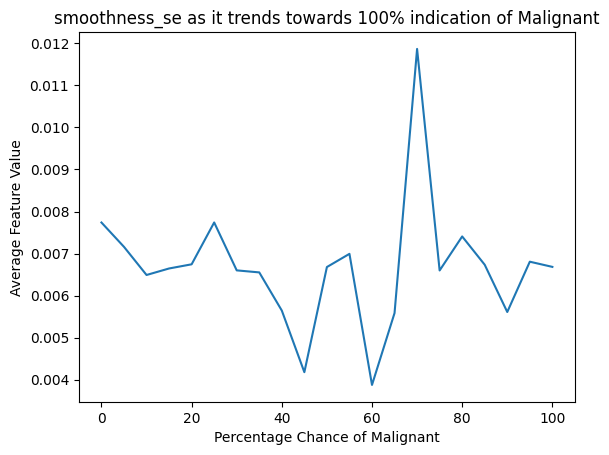

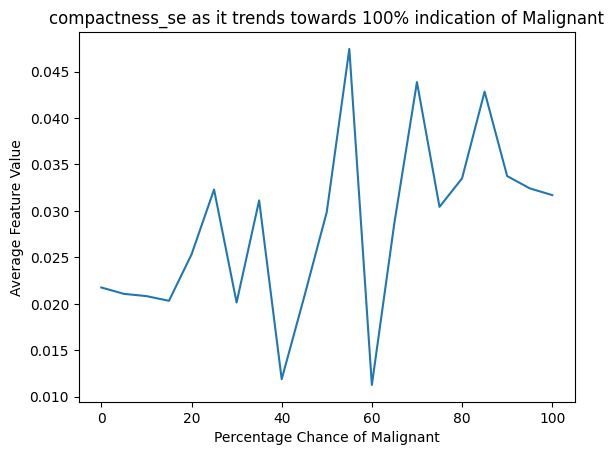

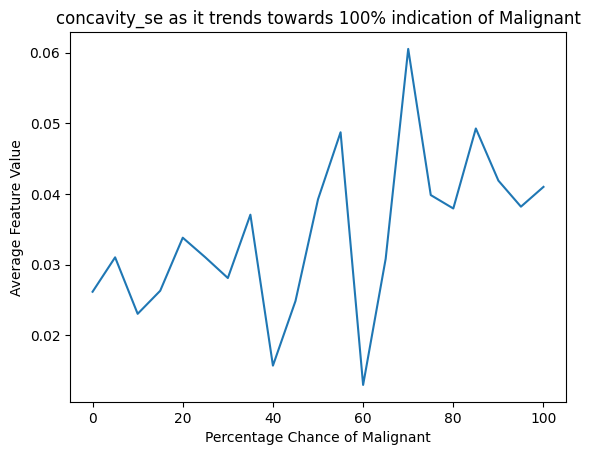

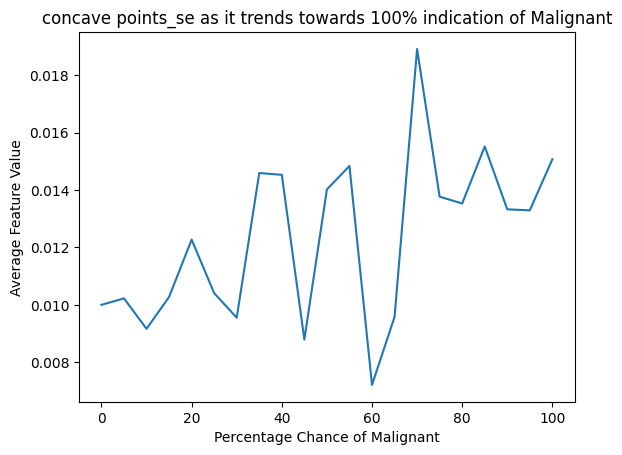

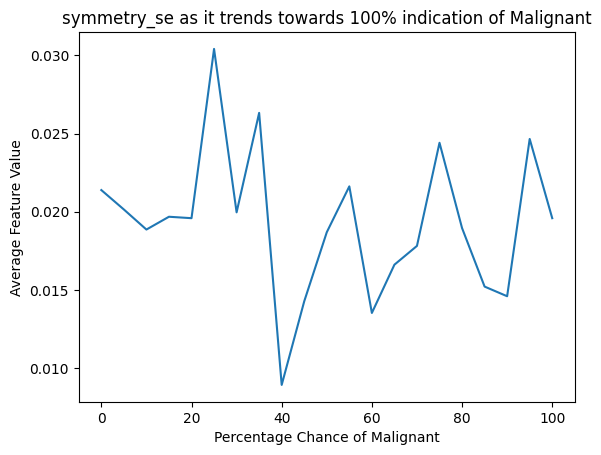

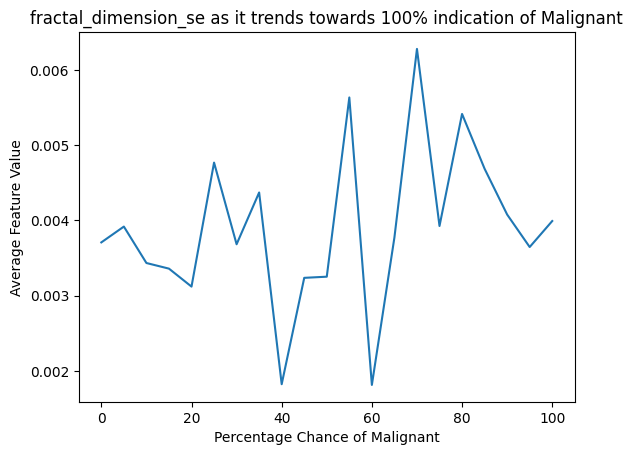

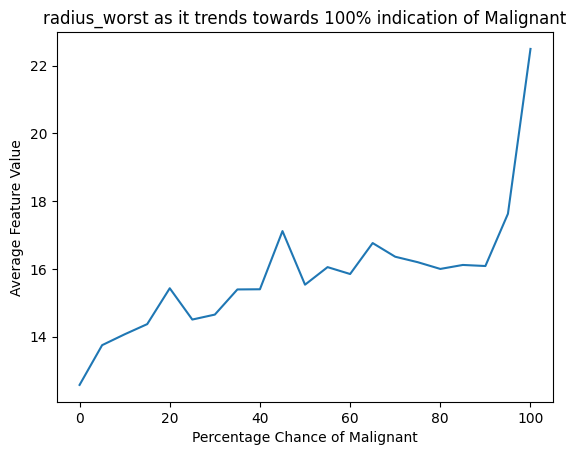

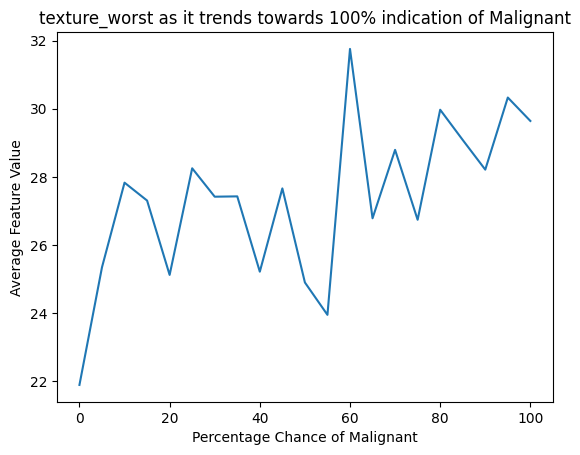

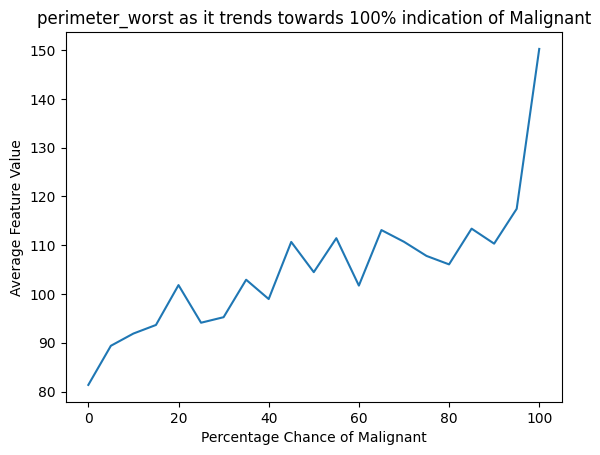

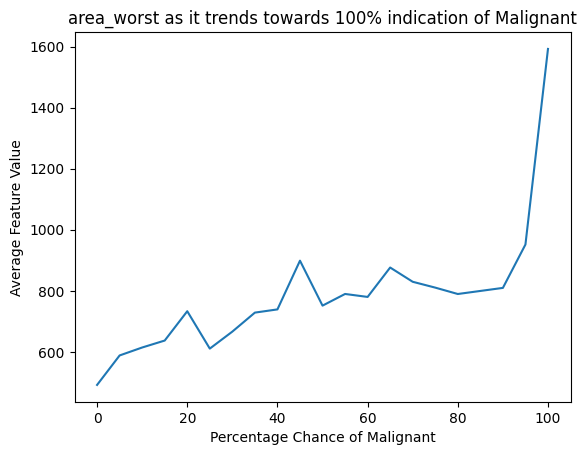

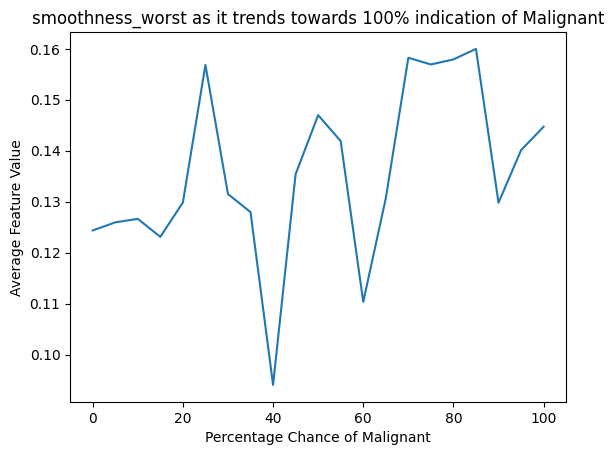

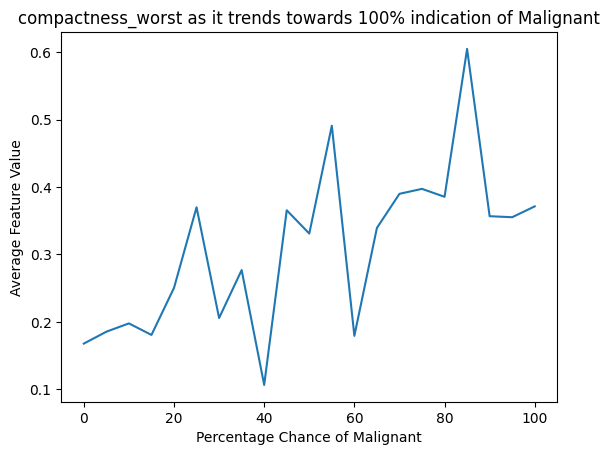

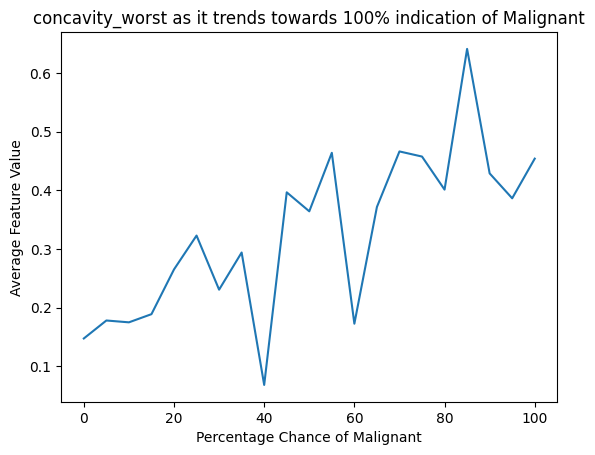

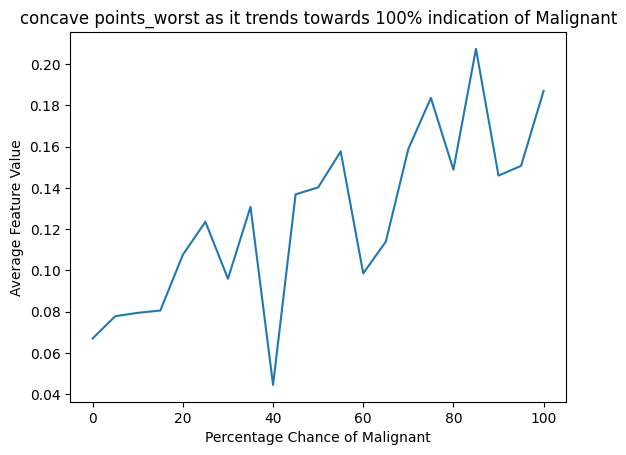

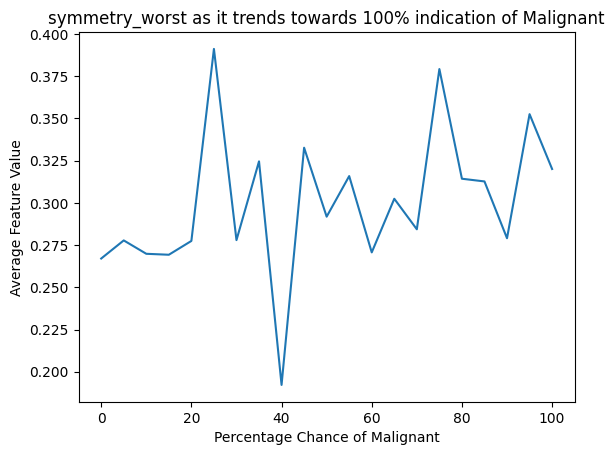

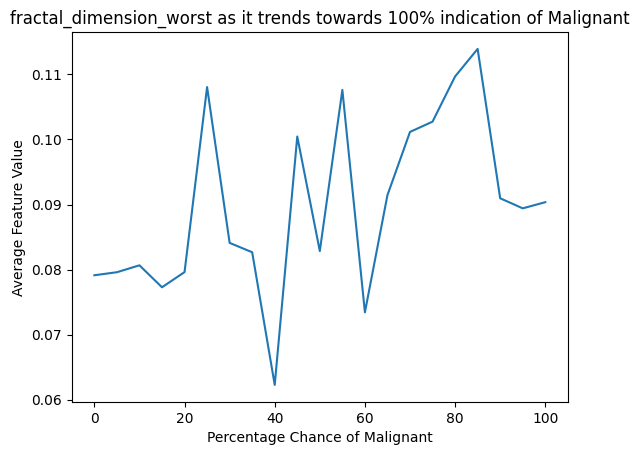

In [59]:
entryPercentiles = dict()
for i in range(0,100+1, 5):
    entryPercentiles.update({i: []})
for i in range(len(lgrProbs)):
    entryPercentiles[floor(5 * round((100 * lgrProbs[i][1]) / 5))].append(i)

def plotFeatureTrend(featureName, featureIndex, header=""):
    xAxis = []
    yAxis = []

    for i in range(0,101,5):
        if(len(entryPercentiles[i]) == 0):
            continue
        featureSum = 0
        for k in entryPercentiles[i]:
            featureSum += X_train[k][featureIndex]
        xAxis.append(i)
        yAxis.append(featureSum / len(entryPercentiles[i]))
    plt.plot(xAxis, yAxis)
    plt.xlabel("Percentage Chance of Malignant")
    plt.ylabel("Average Feature Value")
    plt.title(f'{featureName}{header} as it trends towards 100% indication of Malignant')
    plt.show()

for i in range(len(feature_list)):
    plotFeatureTrend(feature_list[i], i)

### Linear SVC

In [60]:
params = {
    "max_iter": [100000],
    "C": [1]
}

lin = LinearSVC(random_state=42)
avgModelPerformance.append(evalModelPerf(lin, params, X_train_sub, y_train_sub)[0])

Best: 0.935878 using {'C': 1, 'max_iter': 100000}
0.935878 (0.026517) with: {'C': 1, 'max_iter': 100000}


### decision tree

In [61]:
params = {
    "criterion": ["entropy"]
}

clf = tree.DecisionTreeClassifier(random_state=42)

avgModelPerformance.append(evalModelPerf(clf, params, X_train_sub, y_train_sub)[0])

Best: 0.953918 using {'criterion': 'entropy'}
0.953918 (0.020077) with: {'criterion': 'entropy'}


### NN

In [62]:
params = {
    "hidden_layer_sizes": [(100,)],
    "learning_rate_init": [0.001],
    "activation": ["relu"],
    "solver": ["adam"],
    "learning_rate": ["constant"]

}

mlp = MLPClassifier(random_state=42)

avgModelPerformance.append(evalModelPerf(mlp, params, X_train_sub, y_train_sub)[0])

Best: 0.912000 using {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}
0.912000 (0.057411) with: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}


### Scale data, update train/test sets

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, train_size=0.875, random_state=42)

## ML Models Post-Scaling

### SVC

In [64]:
params = {
    "max_iter": [100000],
    "C": [1]
}

lin = LinearSVC(random_state=42)

avgModelPerformance.append(evalModelPerf(lin, params, X_train_sub, y_train_sub)[0])

Best: 0.961959 using {'C': 1, 'max_iter': 100000}
0.961959 (0.028889) with: {'C': 1, 'max_iter': 100000}


### Decision Tree

In [65]:
params = {
    "criterion": ["entropy"]
}

clf = tree.DecisionTreeClassifier(random_state=42)

avgModelPerformance.append(evalModelPerf(clf, params, X_train_sub, y_train_sub)[0])

Best: 0.953918 using {'criterion': 'entropy'}
0.953918 (0.020077) with: {'criterion': 'entropy'}


### NN

In [66]:
params = {
    "hidden_layer_sizes": [(100,)],
    "learning_rate_init": [0.001],
    "activation": ["relu"],
    "solver": ["adam"],
    "learning_rate": ["constant"]

}

mlp = MLPClassifier(random_state=42)

avgModelPerformance.append(evalModelPerf(mlp, params, X_train_sub, y_train_sub)[0])

Best: 0.974000 using {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}
0.974000 (0.020100) with: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}


### Logistic Regression

In [67]:
lgr = LogisticRegression(random_state=0)
lgr.fit(X_train, y_train)
lgrProbs = lgr.predict_proba(X_train)
avgModelPerformance.append(evalModelPerf(lgr, {"random_state": [0]}, X_train_sub, y_train_sub)[0])

Best: 0.965918 using {'random_state': 0}
0.965918 (0.025398) with: {'random_state': 0}


## Visualize model performance pre and post scaling 

Text(0.5, 0, 'Model Type, Pre or Post Scaling, Oversampled')

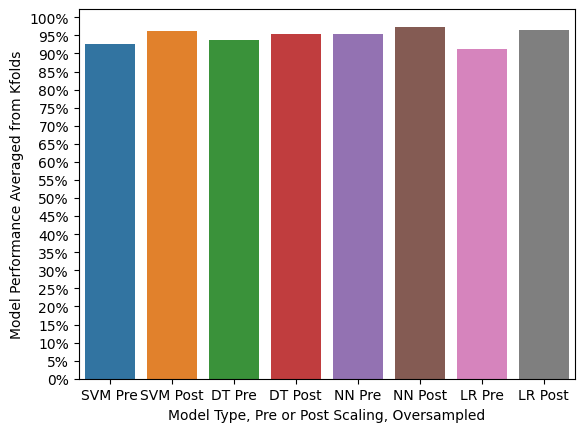

In [68]:
adjacentPerformance = []
for i in range(4):
    adjacentPerformance.append(avgModelPerformance[i] * 100)
    adjacentPerformance.append(avgModelPerformance[i+4] * 100)
ax = sns.barplot(x=np.arange(len(adjacentPerformance)), y=adjacentPerformance)
yticks = [x*5 for x in range(21)]
ylabels = []
for i in range(len(yticks)):
    ylabels.append(f"{yticks[i]}%")
plt.yticks(yticks, ylabels)
modelLabels = ["SVM Pre", "SVM Post", "DT Pre", "DT Post", "NN Pre", "NN Post", "LR Pre", "LR Post"]
plt.xticks(range(8), modelLabels)
plt.ylabel("Model Performance Averaged from Kfolds")
plt.xlabel("Model Type, Pre or Post Scaling, Oversampled")

### Performance Table

[['Linear Support Vector Machine', 92.58367346938776, 96.19591836734693], ['Decision Tree', 93.58775510204082, 95.39183673469388], ['Neural Network', 95.39183673469388, 97.39999999999999], ['Logistic Regression', 91.19999999999999, 96.59183673469387]]
train: 0.9912434325744308
test: 0.972027972027972


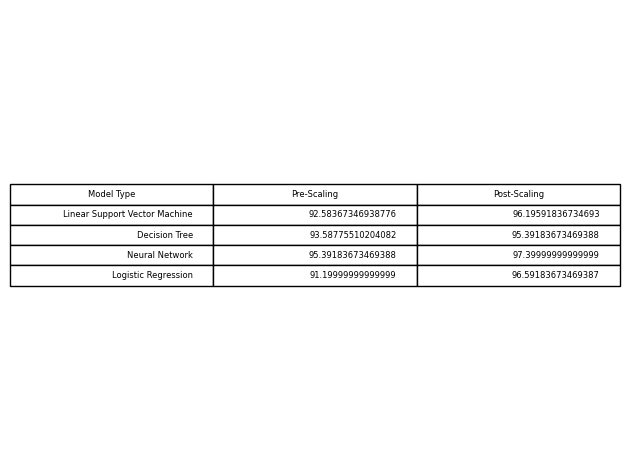

In [69]:
arr = [[None,None,None],[None,None,None],[None,None,None],[None,None,None]]
modelTypes = ["Linear Support Vector Machine", "Decision Tree", "Neural Network", "Logistic Regression"]
arr[0][0] = modelTypes[0]
arr[1][0] = modelTypes[1]
arr[2][0] = modelTypes[2]
arr[3][0] = modelTypes[3]
k = 0
for i in range(0, len(adjacentPerformance), 2):
    arr[k][1] = adjacentPerformance[i]
    arr[k][2] = adjacentPerformance[i+1]
    k += 1
 
print(arr)
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(arr, columns=['Model Type', 'Pre-Scaling', 'Post-Scaling'])
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
mlp.fit(X_train, y_train)
print("train:", accuracy_score(y_train, mlp.predict(X_train)))
print("test:", accuracy_score(y_test, mlp.predict(X_test)))

### LGR again on scaled data

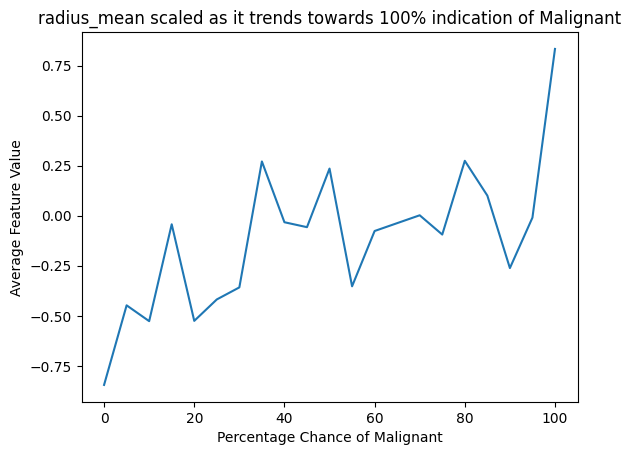

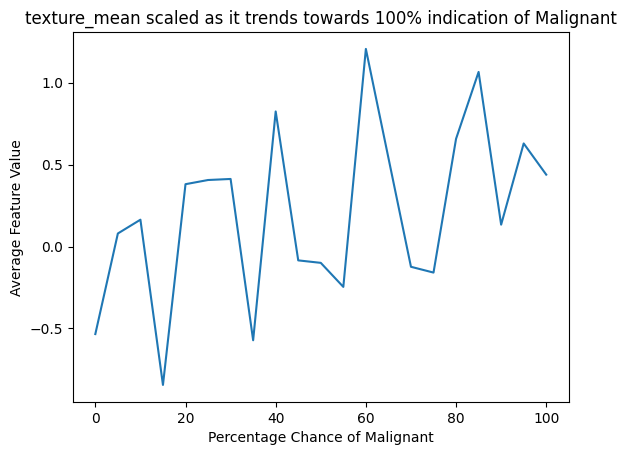

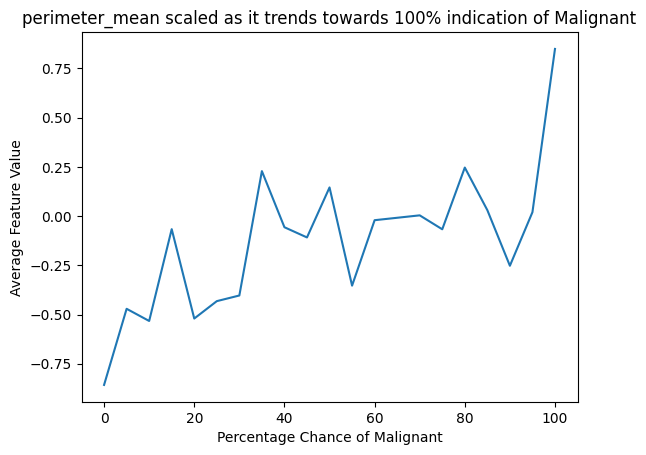

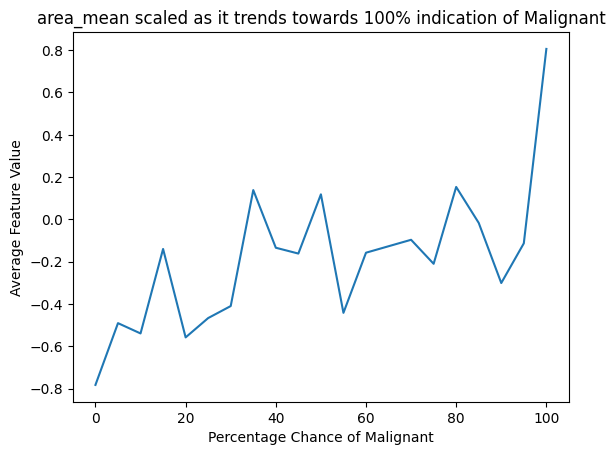

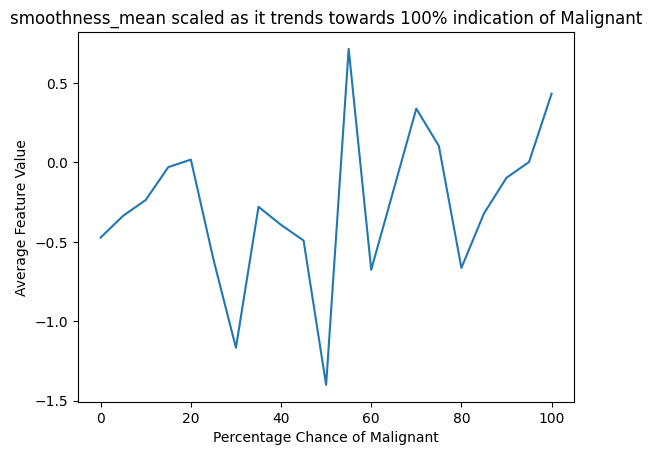

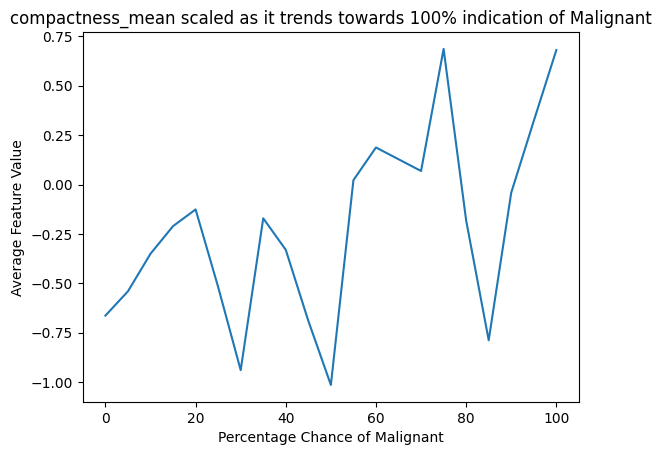

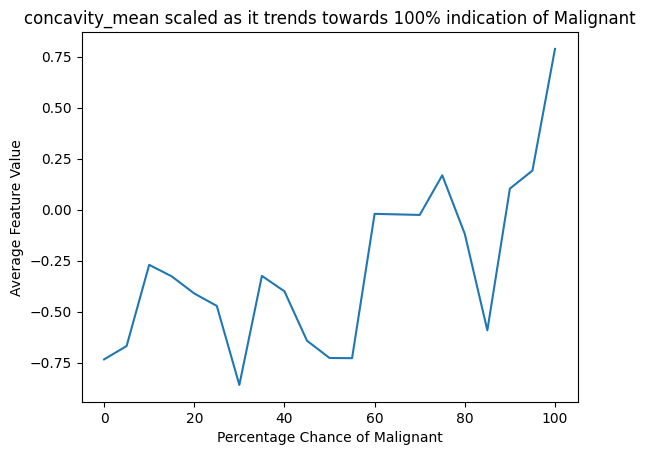

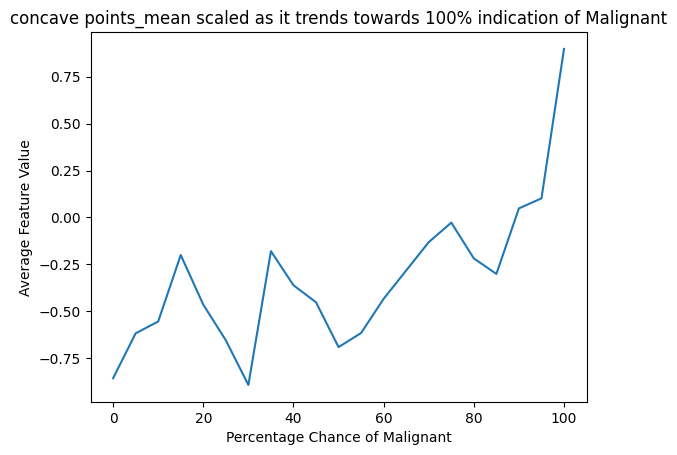

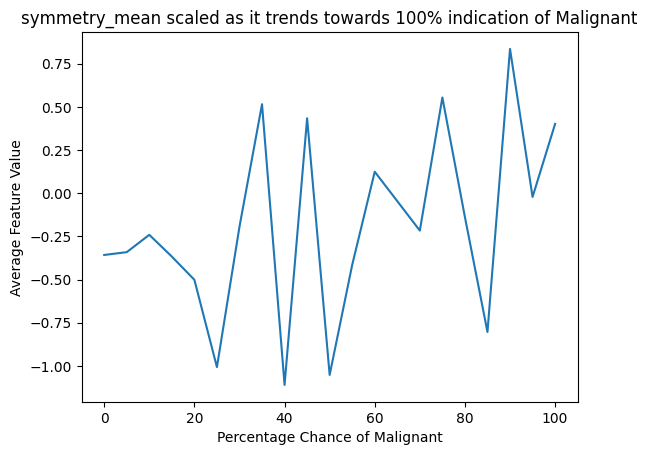

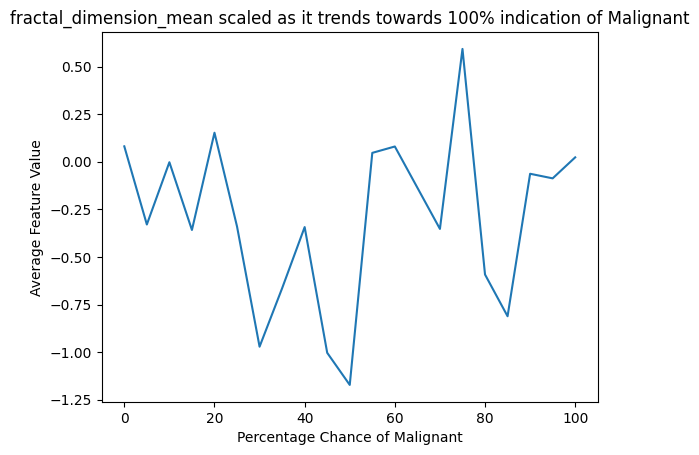

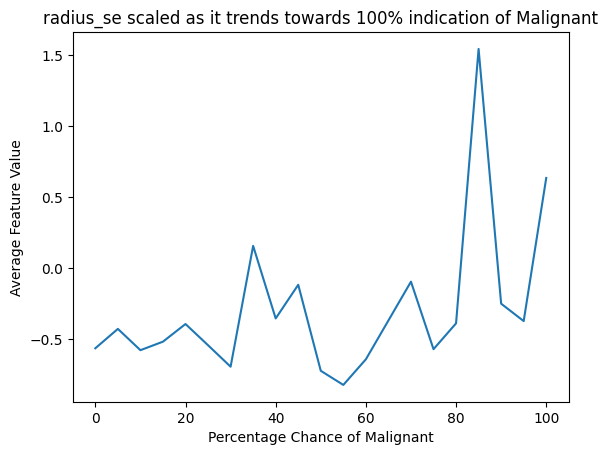

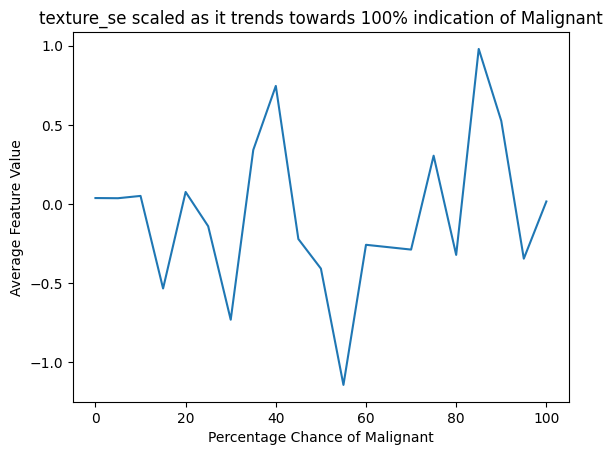

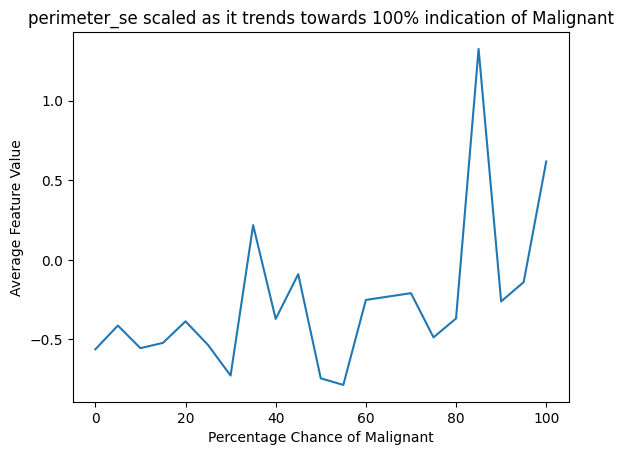

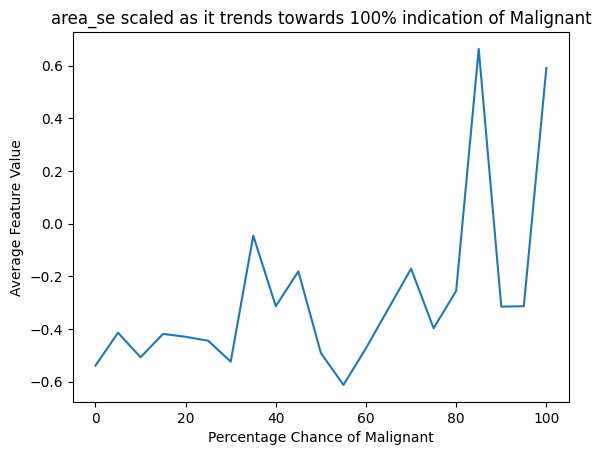

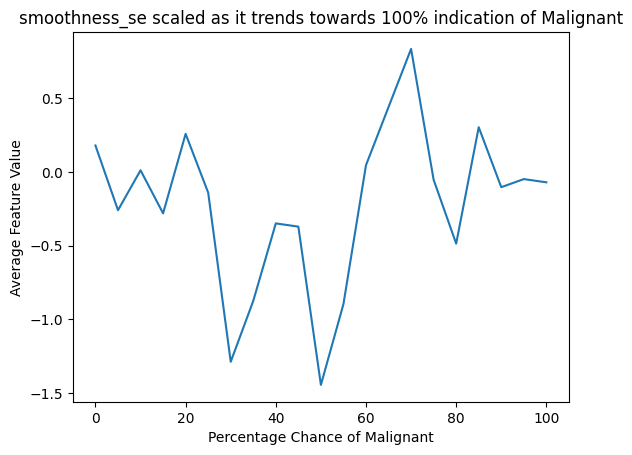

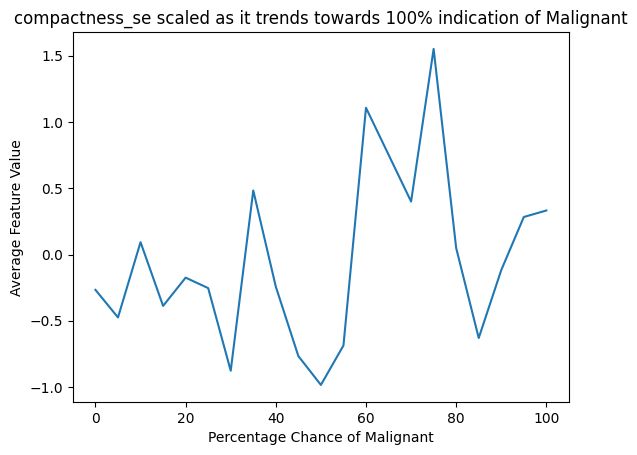

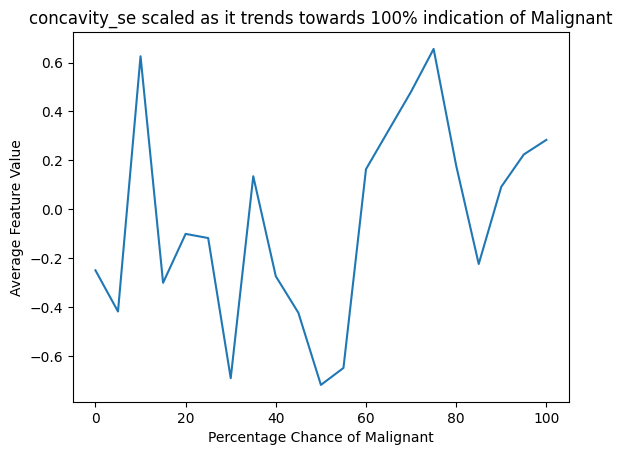

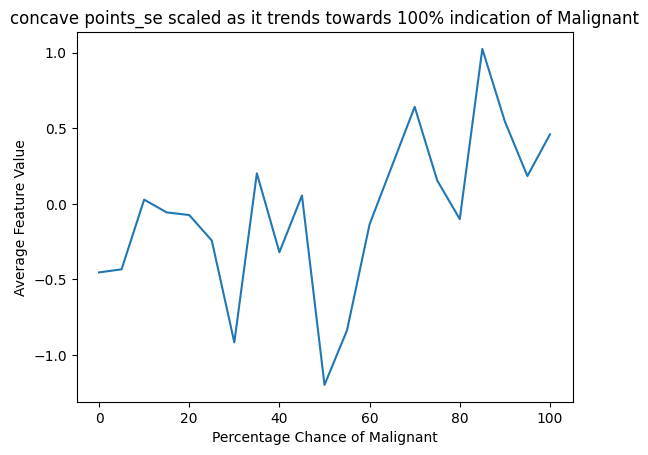

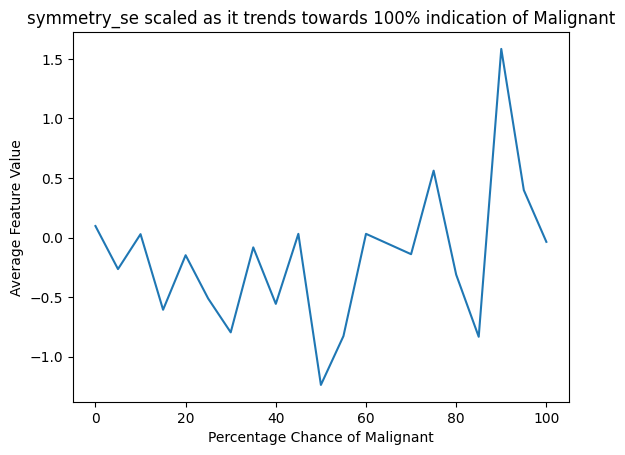

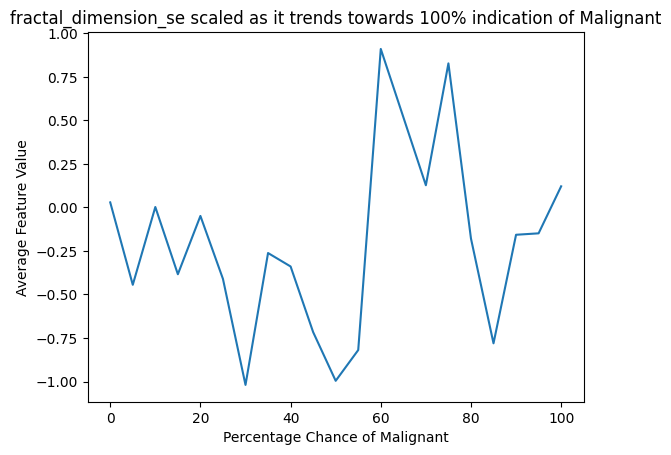

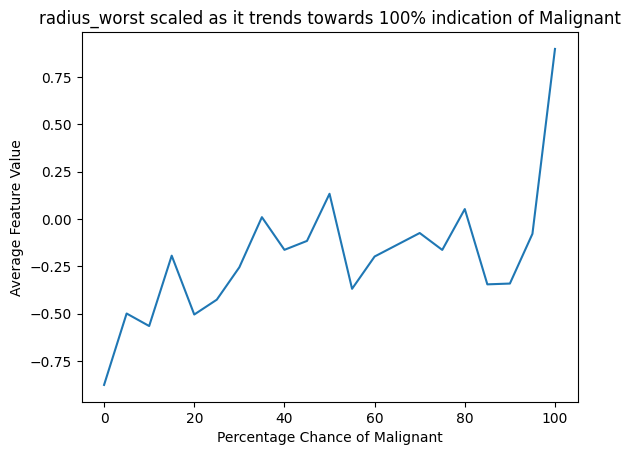

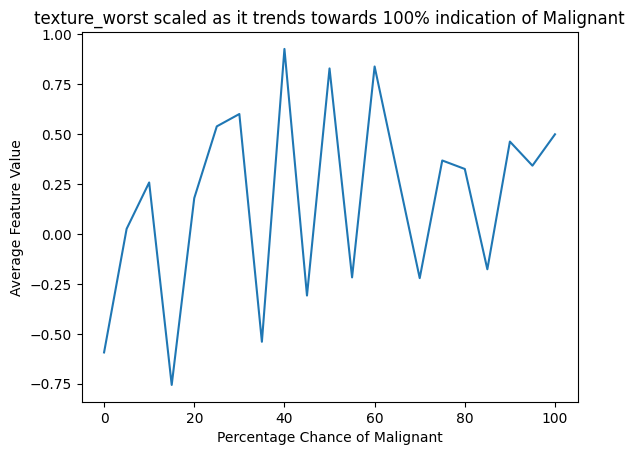

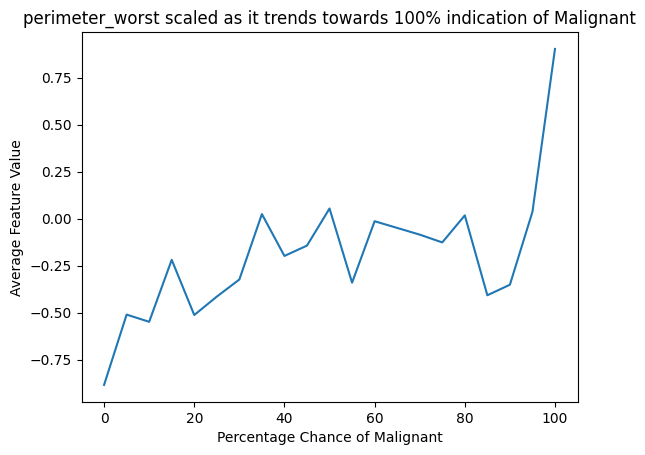

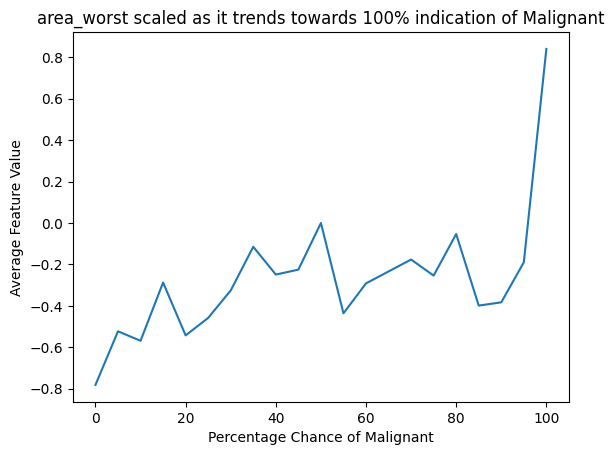

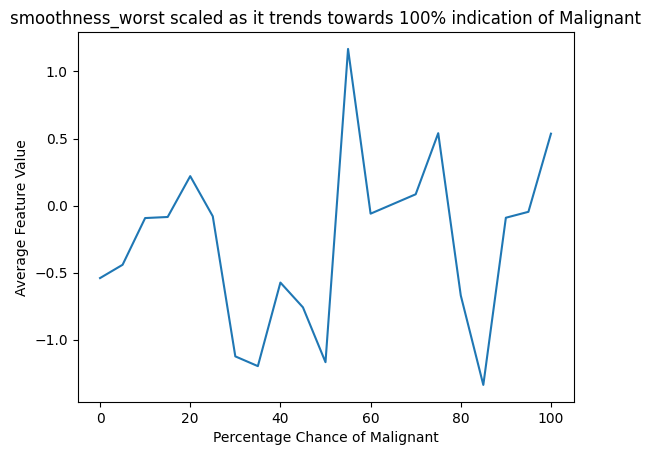

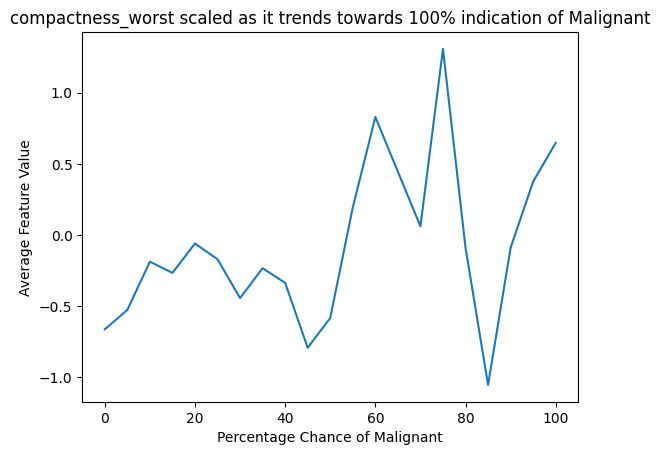

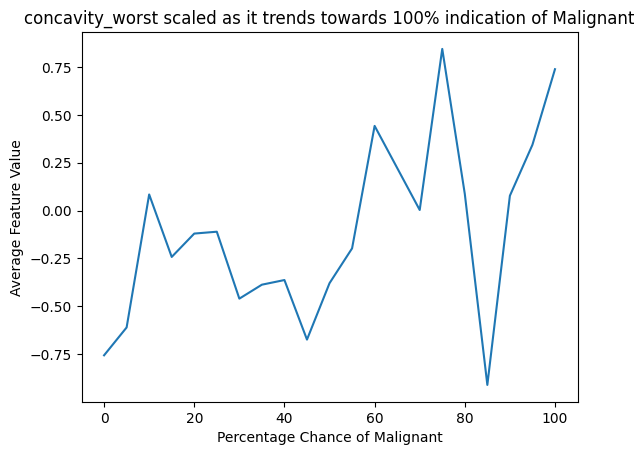

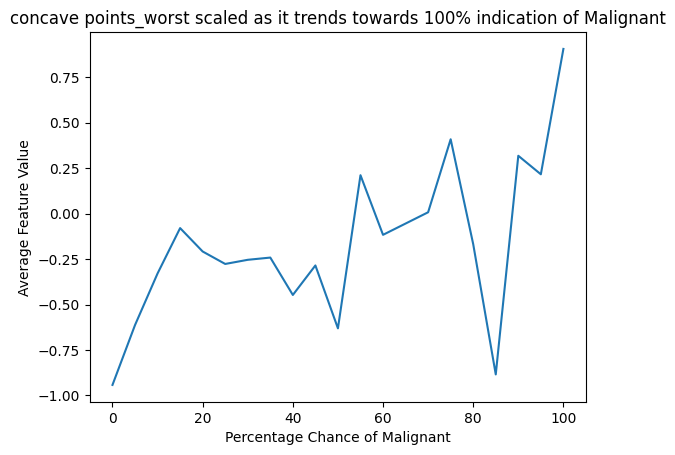

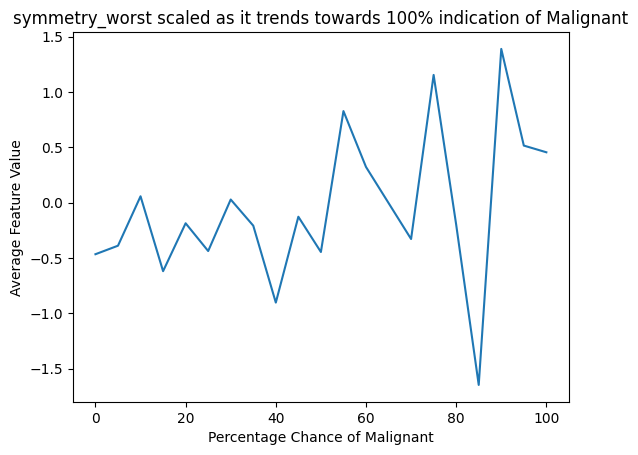

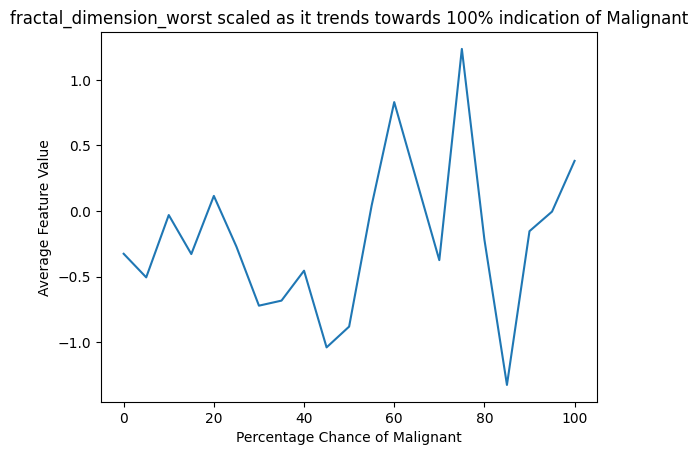

Best: 0.965918 using {'random_state': 0}
0.965918 (0.025398) with: {'random_state': 0}


In [70]:
entryPercentiles = dict()
for i in range(0,100+1, 5):
    entryPercentiles.update({i: []})
for i in range(len(lgrProbs)):
    entryPercentiles[floor(5 * round((100 * lgrProbs[i][1]) / 5))].append(i)
for i in range(len(feature_list)):
    plotFeatureTrend(feature_list[i], i, " scaled")
avgModelPerformance.append(evalModelPerf(lgr, {"random_state": [0]}, X_train_sub, y_train_sub)[0])

### Combining graphs for report

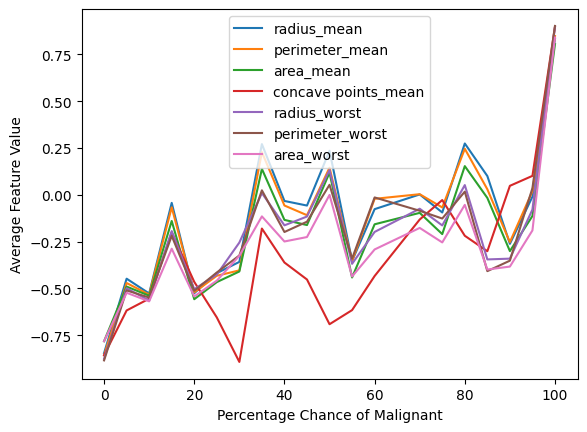

In [71]:
entryPercentiles = dict()
for i in range(0,100+1, 5):
    entryPercentiles.update({i: []})
for i in range(len(lgrProbs)):
    entryPercentiles[floor(5 * round((100 * lgrProbs[i][1]) / 5))].append(i)
for i in range(len(feature_list)):
    if feature_list[i] in ["radius_mean", "perimeter_mean", "area_mean", "concave points_mean", "radius_worst", "perimeter_worst", "area_worst"]:
        
        featureName = feature_list[i]
        featureIndex = i
        header = " scaled"
        
        xAxis = []
        yAxis = []

        for i in range(0,101,5):
            if(len(entryPercentiles[i]) == 0):
                continue
            featureSum = 0
            for k in entryPercentiles[i]:
                featureSum += X_train[k][featureIndex]
            xAxis.append(i)
            yAxis.append(featureSum / len(entryPercentiles[i]))
        plt.plot(xAxis, yAxis, label=featureName)

plt.xlabel("Percentage Chance of Malignant")
plt.ylabel("Average Feature Value")        
leg = plt.legend(loc='upper center')

## Hyperparameter search on NN

In [72]:
#raise #here for generating prior visualizations without oversampling
hidden_layer_sizes = [(100,), (100,100), (100,100,100), (200,), (200,100), (200,100,100), (500), (500,200), (500,200,100)]
learning_rate_init = [0.0001, 0.001, 0.01, 0.1, 1]
params = {
    "hidden_layer_sizes": hidden_layer_sizes,
    "learning_rate_init": learning_rate_init,
}

mlp = MLPClassifier(random_state=42)
means = evalModelPerf(mlp, params, X_train_sub, y_train_sub)[1]

Best: 0.983959 using {'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01}
0.943796 (0.023714) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001}
0.974000 (0.020100) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
0.979959 (0.017889) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
0.981959 (0.016619) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1}
0.959959 (0.021872) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 1}
0.967878 (0.018520) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001}
0.971959 (0.015980) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001}
0.979959 (0.012650) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01}
0.979918 (0.015599) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1}
0.947837 (0.024195) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 1}
0.963918 (0.021557) with: {'hidden_layer_sizes':

### Hyperparameter search visualizations

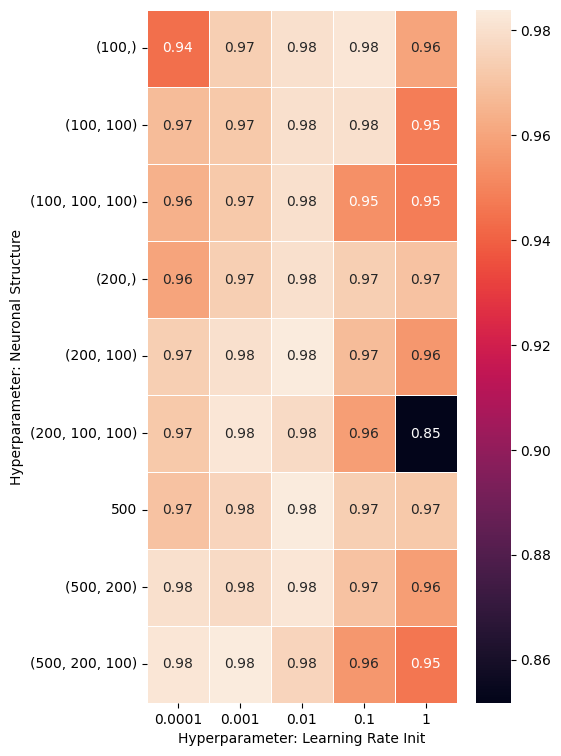

In [73]:
#create matrix of performances, one coordinate represents one combination of hyperparameters
def plotHeatMap(means, x, y, xlabel, ylabel):
    paramMatrix = [[]]
    paramListIndex = 0
    matrixIndex = 0

    for i in range(1, len(means) + 1):
        paramMatrix[matrixIndex].append(means[i - 1])
        if((i % (len(x))) == 0):
            matrixIndex += 1
            paramMatrix.append([])
    if(paramMatrix[len(paramMatrix) - 1] == []):
        paramMatrix.pop()

    f, ax = plt.subplots(figsize=(5, 9))
    sns.heatmap(paramMatrix, annot=True,  linewidths=.5, ax=ax, xticklabels=x, yticklabels=y)

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
plotHeatMap(means, learning_rate_init, hidden_layer_sizes, "Hyperparameter: Learning Rate Init", "Hyperparameter: Neuronal Structure")

### Further hyperparameter search with optimal structure: (200,100), init learning rate: .01

In [74]:
activation = ["tanh", "logistic", "identity", "relu"]
learning_rate = ["constant", "invscaling", "adaptive"]
params = {
    "activation": activation,
    "learning_rate": learning_rate,
    "learning_rate_init": [0.01],
    "hidden_layer_sizes": [(200,100)]
}

mlp = MLPClassifier(random_state=42)
means = evalModelPerf(mlp, params, X_train_sub, y_train_sub)[1]

Best: 0.983959 using {'activation': 'relu', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
0.981959 (0.014006) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
0.981959 (0.014006) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01}
0.981959 (0.014006) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
0.969959 (0.024067) with: {'activation': 'logistic', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.01}
0.969959 (0.024067) with: {'activation': 'logistic', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01}
0.969959 (0.024067) with: {'activation': 'logistic', 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
0.959918 

## final heatmap

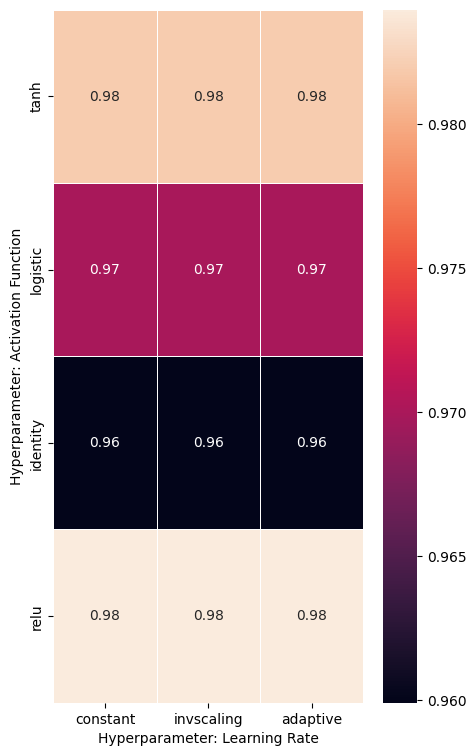

In [75]:
plotHeatMap(means, learning_rate, activation, "Hyperparameter: Learning Rate", "Hyperparameter: Activation Function")

## Train and test accuracy of final MLP

In [76]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 100), learning_rate_init=0.01, activation="relu", solver="adam", learning_rate="constant", random_state=42)
mlp.fit(X_train, y_train)
print("train:", accuracy_score(y_train, mlp.predict(X_train)))
print("test:", accuracy_score(y_test, mlp.predict(X_test)))

train: 1.0
test: 0.9790209790209791


## Ranking feature importance, post-scaling

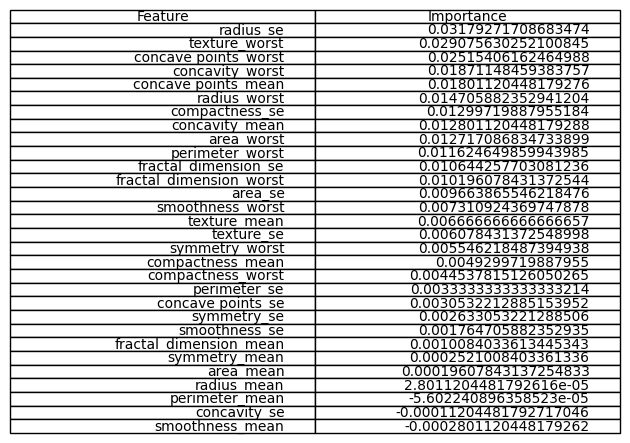

In [77]:
def modelFeatureRanking(model, X, y):
    model_importance_ranking = permutation_importance(model, X, y, n_repeats=50, random_state=42)
    feature_ranking = []
    for i in model_importance_ranking.importances_mean.argsort()[::-1]:
        feature_ranking.append([feature_list[i], model_importance_ranking.importances_mean[i]])
    return feature_ranking

arr = modelFeatureRanking(mlp, X, y)
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(arr, columns=['Feature', 'Importance'])
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
plt.show()

## Ranking feature importance, pre-scaling

train: 0.8143607705779334
test: 0.8391608391608392


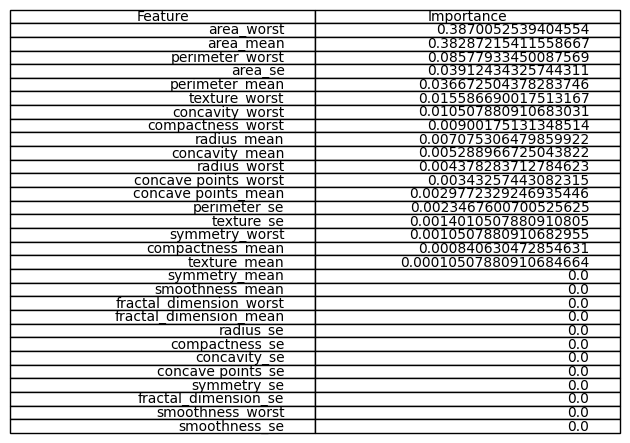

In [78]:
#model has to be retrained for feature importance
X_unscaled, y_unscaled = oversample_data(X_unscaled, y)
#create training/testing set
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y_unscaled, train_size=0.8, random_state=42)
mlpUnscaled = MLPClassifier(random_state=42) #returned to default param MLP, hyperparameter tuned model fits poorly to unscaled data
mlpUnscaled.fit(X_train_unscaled, y_train_unscaled)
print("train:", accuracy_score(y_train, mlpUnscaled.predict(X_train)))
print("test:", accuracy_score(y_test, mlpUnscaled.predict(X_test)))
arr = modelFeatureRanking(mlpUnscaled, X_train_unscaled, y_train_unscaled)
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(arr, columns=['Feature', 'Importance'])
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()

### Feature pruning for pre-post scaled data
- Can run on pre or post scaling data/models
- visualize feature-ranking post pruning
- correlation matrix of data

Number of features pruned:  15
radius_mean
perimeter_mean
area_mean
smoothness_mean
compactness_mean
symmetry_mean
fractal_dimension_mean
texture_se
perimeter_se
smoothness_se
concavity_se
concave points_se
symmetry_se
compactness_worst
fractal_dimension_worst
train: 1.0
test: 0.972027972027972


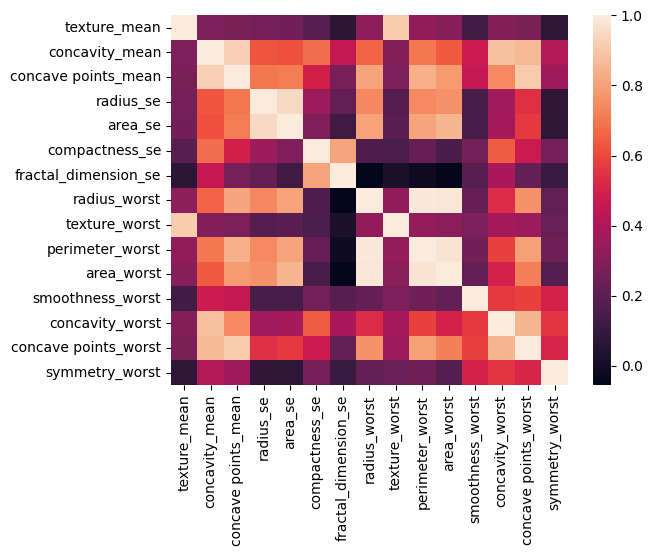

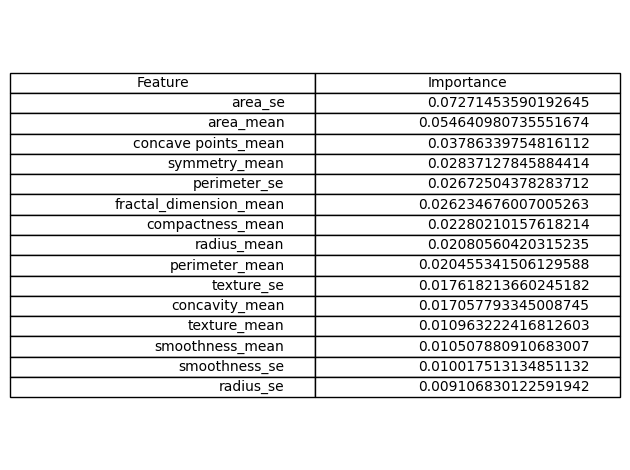

In [79]:
# Perform permutation importance on the model
perm = PermutationImportance(mlp, cv=10, random_state=42)
perm.fit(np.asarray(X_train), np.asarray(y_train))

# Use the permutation importance results to prune the features
featureTransformer = SelectFromModel(perm, threshold=0.005, prefit=True)
X_pruned = featureTransformer.transform(X_train)
X_test_pruned = featureTransformer.transform(X_test)

print("Number of features pruned: ", X_train.shape[1] - X_pruned.shape[1])
features_prune_list = featureTransformer.get_support()
preserved_features = []
for i in range(len(features_prune_list)):
    if features_prune_list[i] == False:
        print(feature_list[i])

    else:
        preserved_features.append(feature_list[i])

prunedScaledDf = pd.DataFrame(columns=preserved_features, data=X_pruned)
sns.heatmap(prunedScaledDf.corr())
# Train the model on the pruned dataset
mlp.fit(X_pruned, y_train)
print("train:", accuracy_score(y_train, mlp.predict(X_pruned)))
print("test:", accuracy_score(y_test, mlp.predict(X_test_pruned)))

arr = modelFeatureRanking(mlp, X_pruned, y_train)
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(arr, columns=['Feature', 'Importance'])
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
plt.show()